# Autoregression in the regression model with storm surge

This R notebook implements ARIMAX models for the sea water level data. Storm surge is an independent variable.

#### Remark

This notebook uses as an input a Python data frame created in the notebook Structural_Breaks_CUSUM_Py.

In [1]:
# ... and load the required libraries
library(zoo)
library(TSA)
library(tseries)
library(sandwich) 
library(lmtest)
library(ggplot2)
library(strucchange)
#library(coeftest) # in lmtest

Warning message:
"package 'zoo' was built under R version 3.4.4"
Attaching package: 'zoo'

The following objects are masked from 'package:base':

    as.Date, as.Date.numeric

Warning message:
"package 'TSA' was built under R version 3.4.4"
Attaching package: 'TSA'

The following objects are masked from 'package:stats':

    acf, arima

The following object is masked from 'package:utils':

    tar

Warning message:
"package 'tseries' was built under R version 3.4.4"Warning message:
"package 'sandwich' was built under R version 3.4.4"Warning message:
"package 'lmtest' was built under R version 3.4.4"Warning message:
"package 'ggplot2' was built under R version 3.4.4"Warning message:
"package 'strucchange' was built under R version 3.4.4"

In [2]:
# Read R data frame from  laad het dataframe in van het gewenste station
df <- readRDS("df_sea_surge.RDS")
print(head(df))

  year    height      surge
0 1890 -194.6667 -0.9605491
1 1891 -179.0000 -0.9605491
2 1892 -166.5000 -0.9605491
3 1893 -142.1667 -0.9605491
4 1894 -141.8333 -0.9605491
5 1895 -173.0000 -0.9605491


In [3]:
# Extend converted Python data frame with nodal cycle (phase shift and amplitude will be estimated, fixed cycle is known well).
df$trend = df$year - 1970
df$costerm = cos(2*pi*(df$year-1970)/18.613)
df$sinterm = sin(2*pi*(df$year-1970)/18.613)

# Method 1
#model <- df$height ~ df$trend + df$costerm + df$sinterm + df$surge
#sea.lm <- lm(model)
#summary(sea.lm)

# Method 2
model <- height ~ trend + costerm + sinterm + surge
sea.lm <- lm(model, data = df)
summary(sea.lm) # without heteroskedastic standard errors
##summary(sea.lm, robust=T) # with h.s.e., yields the same result


Call:
lm(formula = model, data = df)

Residuals:
    Min      1Q  Median      3Q     Max 
-72.103 -13.643   1.374  14.523  57.535 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) -23.11422    2.48189  -9.313 6.16e-16 ***
trend         1.92672    0.06151  31.324  < 2e-16 ***
costerm       4.52725    3.20995   1.410 0.160952    
sinterm     -10.86845    3.21171  -3.384 0.000959 ***
surge         0.90179    0.14408   6.259 5.88e-09 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 25.57 on 123 degrees of freedom
Multiple R-squared:  0.8925,	Adjusted R-squared:  0.889 
F-statistic: 255.2 on 4 and 123 DF,  p-value: < 2.2e-16


In [4]:
# Some R code for robust fitting. # The package sandwich, also included in strucchange, consists of 
# several methods to correct for heteroskedasticity and autocorrelation. See also:
# https://stackoverflow.com/questions/4385436/regression-with-heteroskedasticity-corrected-standard-errors
# Be careful with the model definition and the model fit.

# Slightly different model definition
modeldf <- df$height ~ df$trend + df$costerm + df$sinterm + df$surge

# Heteroskedasticity corrected standard errors
(wtest <- waldtest(modeldf, vcov=vcovHC))
print(wtest)
(ctest <- coeftest(sea.lm, vcov. = vcovHC))
#print(ctest)

Res.Df,Df,F,Pr(>F)
123,NA,NA,NA
127,-4,367.5905,2.23047e-67


Wald test

Model 1: df$height ~ df$trend + df$costerm + df$sinterm + df$surge
Model 2: df$height ~ 1
  Res.Df Df      F    Pr(>F)    
1    123                        
2    127 -4 367.59 < 2.2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1



t test of coefficients:

              Estimate Std. Error t value  Pr(>|t|)    
(Intercept) -23.114220   2.314602 -9.9863 < 2.2e-16 ***
trend         1.926716   0.057570 33.4676 < 2.2e-16 ***
costerm       4.527245   3.217467  1.4071  0.161924    
sinterm     -10.868449   3.297294 -3.2962  0.001281 ** 
surge         0.901794   0.078961 11.4208 < 2.2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1


In [5]:
# HAC standard errors (robust against heteroskedasticity and autocorrelation)

# modeldf <- df$height ~ df$trend + df$costerm + df$sinterm + df$surge
# (wtest <- waldtest(modeldf, vcov=vcovHC))
# print(wtest)
(ctest <- coeftest(sea.lm, vcov. = vcovHAC))
#print(ctest)


t test of coefficients:

              Estimate Std. Error t value  Pr(>|t|)    
(Intercept) -23.114220   2.756352 -8.3858 9.834e-14 ***
trend         1.926716   0.065426 29.4488 < 2.2e-16 ***
costerm       4.527245   3.484832  1.2991  0.196330    
sinterm     -10.868449   3.600501 -3.0186  0.003088 ** 
surge         0.901794   0.073413 12.2838 < 2.2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1


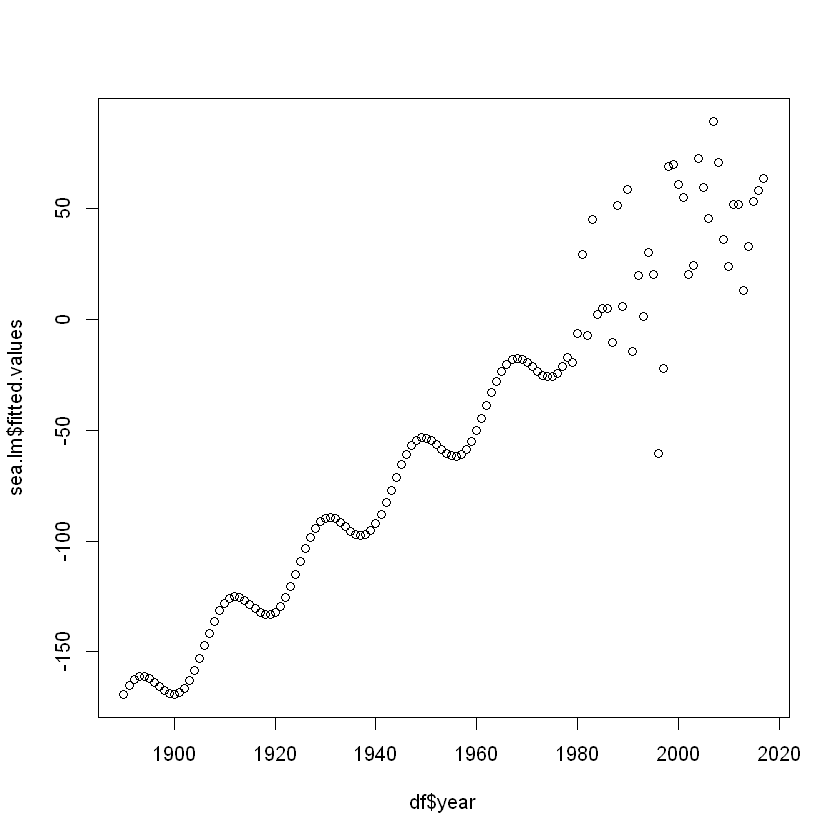

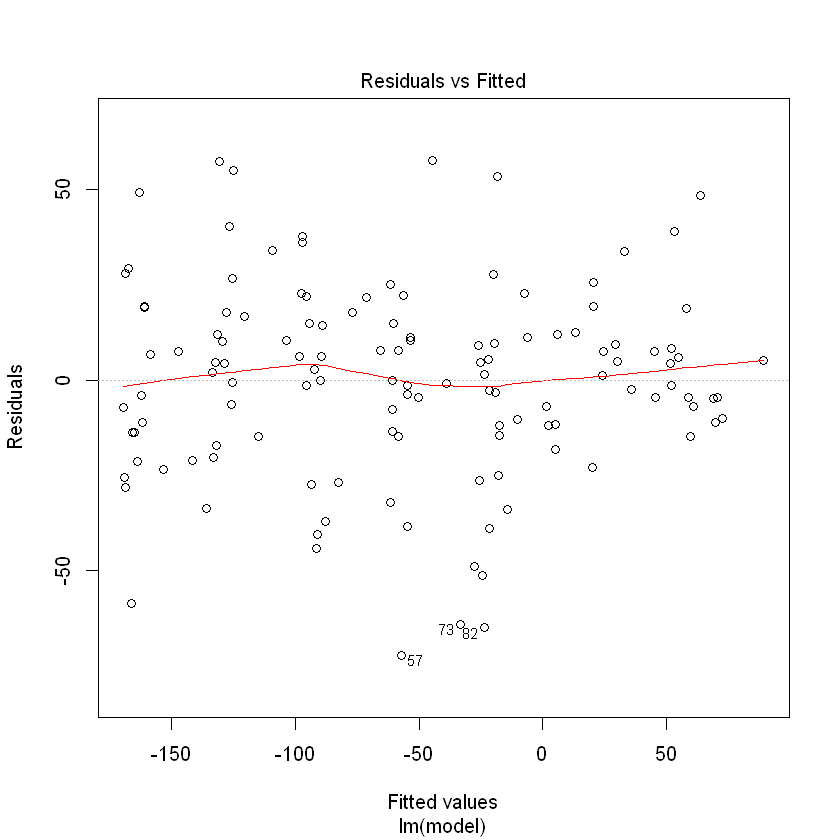

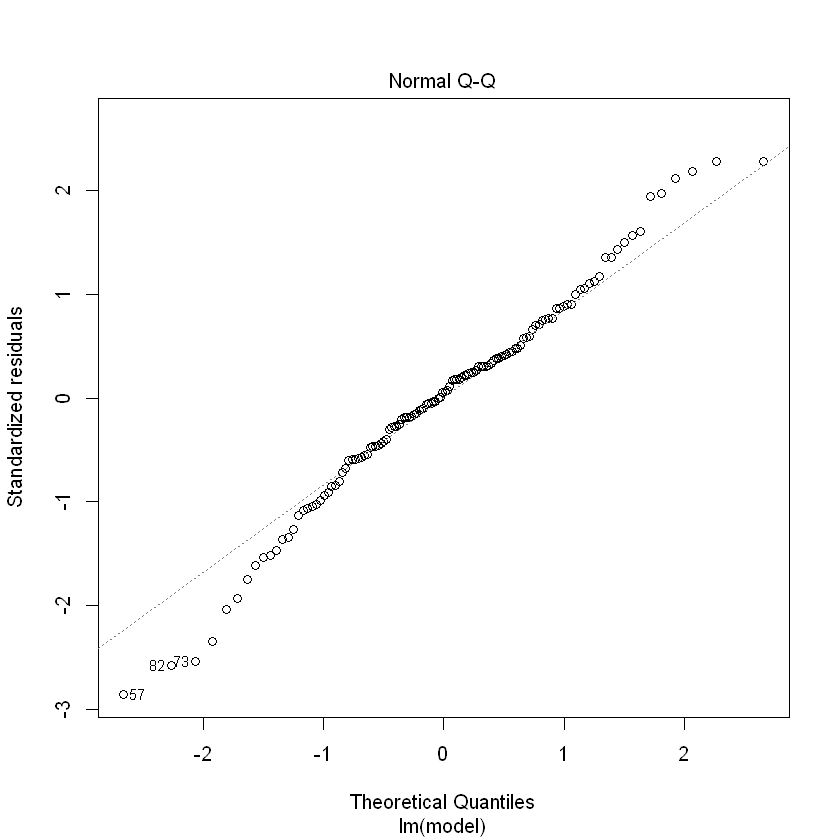

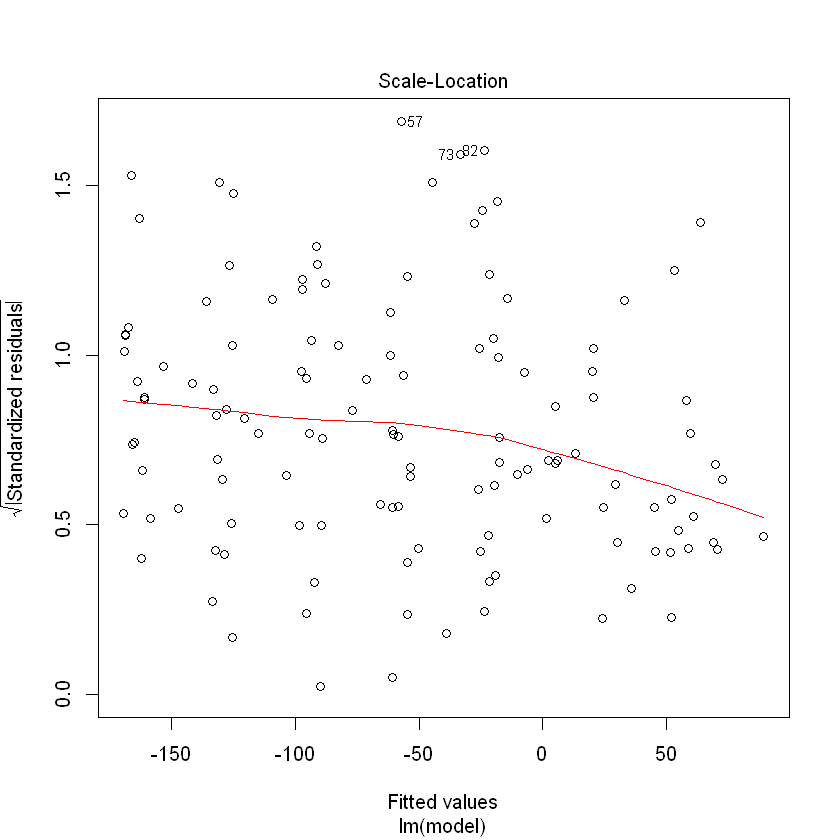

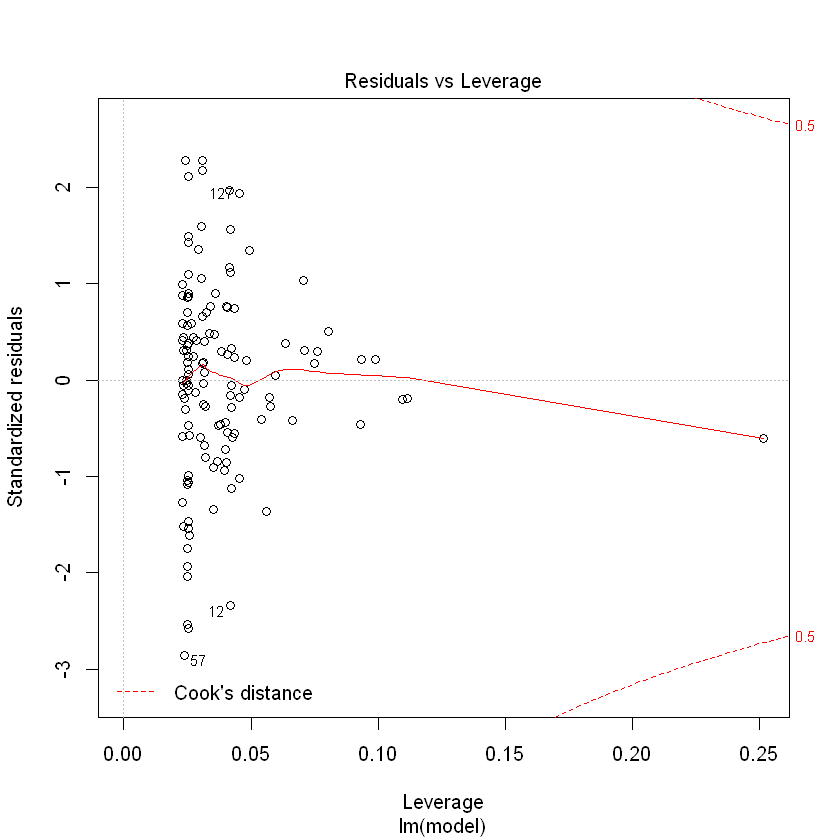

In [6]:
# Some diagnostic plots of the residuals
plot(df$year,sea.lm$fitted.values)
plot(sea.lm)

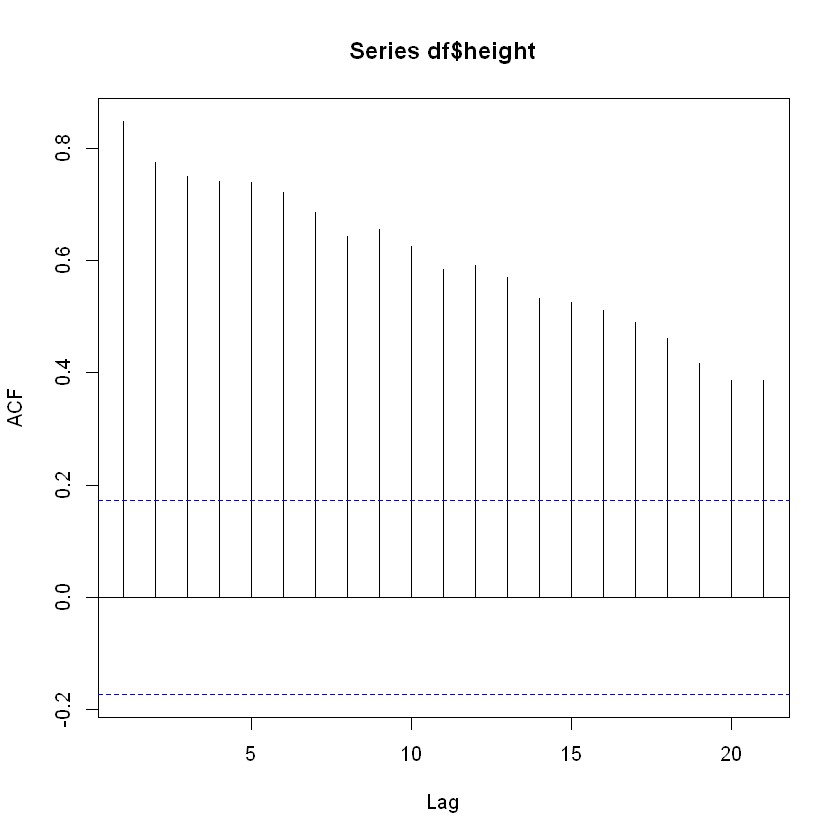

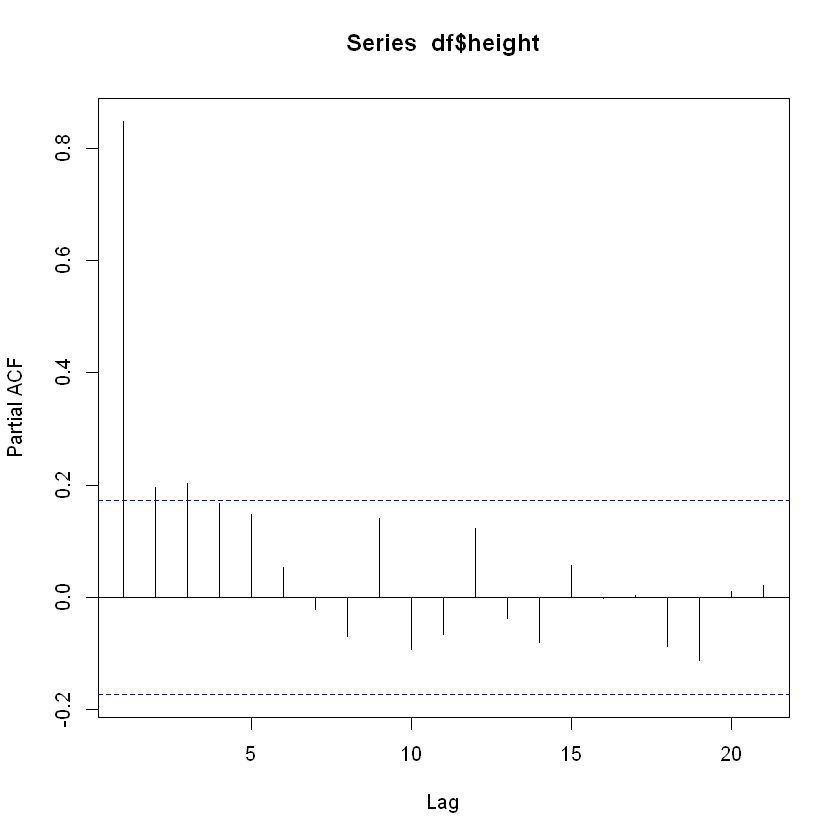

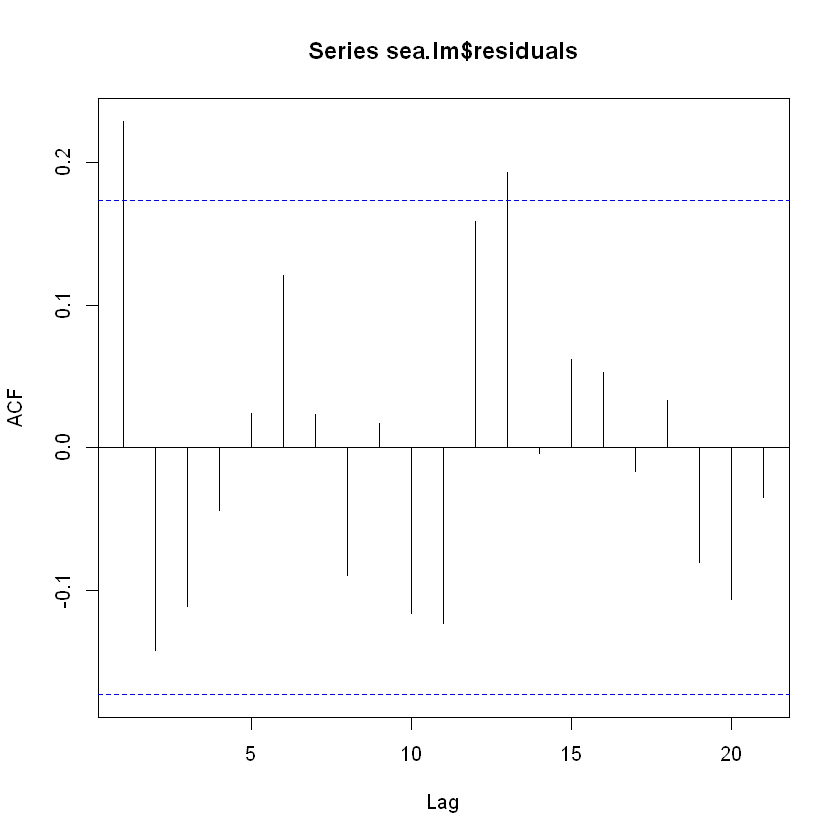

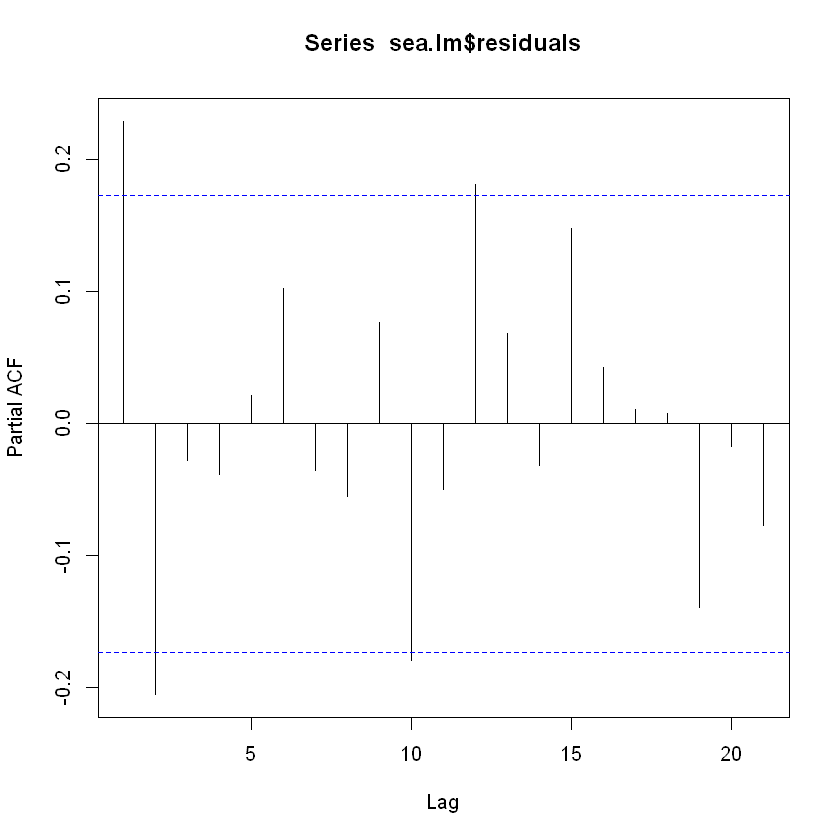

In [14]:
# Autocorrelation functions
acf(df$height)
pacf(df$height)

acf(sea.lm$residuals)
pacf(sea.lm$residuals)

In [15]:
# Unit root in sea water levels?
adf.test(df$height)

Warning message in adf.test(df$height):
"p-value smaller than printed p-value"


	Augmented Dickey-Fuller Test

data:  df$height
Dickey-Fuller = -4.4266, Lag order = 5, p-value = 0.01
alternative hypothesis: stationary


In [17]:
# Set up a ARX(1) model
xregs = cbind(df$trend,df$costerm,df$sinterm,df$surge)
colnames(xregs) <- c('trend','costerm','sinterm','surge')

(arxmodel <- arimax(df$height, order=c(1,0,0), xreg=xregs))
#summary(arxmodel)


Call:
arimax(x = df$height, order = c(1, 0, 0), xreg = xregs)

Coefficients:
         ar1  intercept   trend  costerm   sinterm   surge
      0.2373   -22.8967  1.9352   4.4329  -10.9083  0.9242
s.e.  0.0874     3.0906  0.0764   3.9117    3.9128  0.1342

sigma^2 estimated as 593.7:  log likelihood = -590.38,  aic = 1192.76

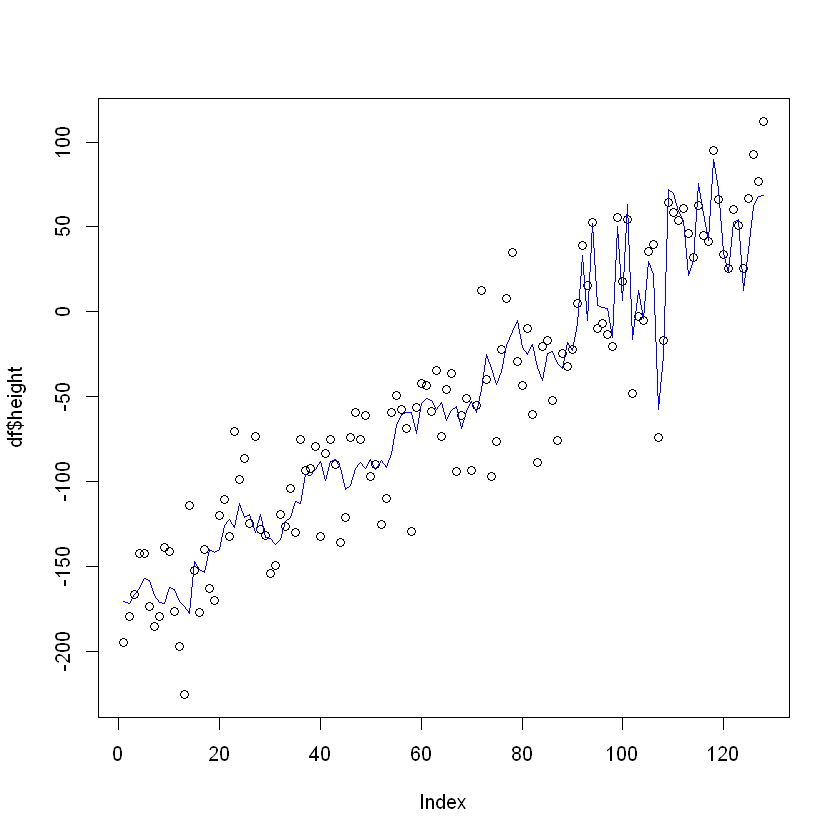

In [23]:
#plot(arxmodel)
plot(df$height)
lines(fitted(arxmodel),col="blue")